In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu

In [3]:
aspects = [
    'hotel#general', 'hotel#prices', 'hotel#design&features', 'hotel#cleanliness', 'hotel#comfort', 'hotel#quality', 'hotel#miscellaneous',
    'rooms#general', 'rooms#prices', 'rooms#design&features', 'rooms#cleanliness', 'rooms#comfort', 'rooms#quality', 'rooms#miscellaneous',
    'room_amenities#general', 'room_amenities#prices', 'room_amenities#design&features', 'room_amenities#cleanliness', 'room_amenities#comfort', 'room_amenities#quality', 'room_amenities#miscellaneous',
    'facilities#general', 'facilities#prices', 'facilities#design&features', 'facilities#cleanliness', 'facilities#comfort', 'facilities#quality', 'facilities#miscellaneous',
    'service#general',
    'location#general',
    'food&drinks#prices', 'food&drinks#quality', 'food&drinks#style&options', 'food&drinks#miscellaneous' ]

sentiments = ['dne', 'positive', 'negative', 'neutral']
all_keys = aspects

In [4]:
# Chuyển định dạng reviews từ file .txt -> Dataframe
def text2df(filepath, all_keys=all_keys):
    
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
        
    blocks = re.split(r'(?m)^#\d+\s*', text.strip())
    blocks = [b.strip() for b in blocks if b.strip()]

    data, found_keys = [], set()
    for b in blocks:
        parts = b.rsplit('\n', 1)
        review, ann_line = parts if len(parts) == 2 else (b, "")
        anns = re.findall(r'\{([^,{}]+),\s*([^{}]+)\}', ann_line)
        anns = [(a.strip().lower(), s.strip().lower()) for a, s in anns]
        found_keys.update(a for a, _ in anns)
        data.append((review.strip(), anns))

    rows = []
    for review, anns in data:
        row = {"review": review}
        for k in all_keys:
            row[k] = np.nan
        for a, s in anns:
            if a in row:
                row[a] = s
        rows.append(row)

    return pd.DataFrame(rows)

In [4]:
data = text2df("Data/data_full.txt")

# Chia dữ liệu: Stratified Split

In [5]:
from skmultilearn.model_selection import iterative_train_test_split

y_binary = data[aspects].notna().astype(int).to_numpy()
X_indices = data.index.to_numpy().reshape(-1, 1)

print(f"Tổng số mẫu ban đầu: {len(data)}")
print("-" * 30)

# BƯỚC 1: Tách Train (70%) và Phần còn lại (30%)
X_train_idx, y_train_binary, X_rem_idx, y_rem_binary = iterative_train_test_split(
    X_indices, y_binary, test_size=0.3
)

X_val_idx, y_val_binary, X_test_idx, y_test_binary = iterative_train_test_split(
    X_rem_idx, y_rem_binary, test_size=0.5
)

train_df = data.loc[X_train_idx.flatten()].copy()
val_df   = data.loc[X_val_idx.flatten()].copy()
test_df  = data.loc[X_test_idx.flatten()].copy()

# 4. KIỂM TRA LẠI TỶ LỆ
n_total = len(data)
print(f"1. Tập Train: {len(train_df)} mẫu ({len(train_df)/n_total*100:.2f}%)")
print(f"2. Tập Val:   {len(val_df)} mẫu   ({len(val_df)/n_total*100:.2f}%)")
print(f"3. Tập Test:  {len(test_df)} mẫu  ({len(test_df)/n_total*100:.2f}%)")

Tổng số mẫu ban đầu: 2389
------------------------------
1. Tập Train: 1658 mẫu (69.40%)
2. Tập Val:   359 mẫu   (15.03%)
3. Tập Test:  372 mẫu  (15.57%)


# Định nghĩa thống kê

In [10]:
def get_text_stats(text_series):
    all_tokens = [str(text).split() for text in text_series]
    
    lengths = [len(tokens) for tokens in all_tokens]
    avg_len = np.mean(lengths)
    
    flat_tokens = [word.lower() for tokens in all_tokens for word in tokens]
    vocab_size = len(set(flat_tokens))
    
    return avg_len, vocab_size, lengths

In [11]:
text_col = 'review' # Tên cột chứa nội dung review
aspect_cols = [c for c in data.columns if c != text_col and c != 'id'] 

df_long = data.melt(id_vars=[text_col], 
                  value_vars=aspect_cols, 
                  var_name='Aspect_Raw', 
                  value_name='Polarity')

df_long = df_long.dropna(subset=['Polarity'])

df_long[['Category', 'Attribute']] = df_long['Aspect_Raw'].str.split('#', expand=True)

# --- TẠO BẢNG THỐNG KÊ ---
summary_table = pd.crosstab(df_long['Aspect_Raw'], df_long['Polarity'])

df_long = data.melt(id_vars=[text_col], 
                  value_vars=aspect_cols, 
                  var_name='Aspect_Raw', 
                  value_name='Polarity')

df_long = df_long.dropna(subset=['Polarity'])


expected_labels = ['positive', 'negative', 'neutral']

summary_table = summary_table.reindex(columns=expected_labels, fill_value=0)

summary_table['Total_Samples'] = summary_table[expected_labels].sum(axis=1)

# Sắp xếp
summary_table = summary_table.sort_values('Total_Samples', ascending=False)

print("\n=== BẢNG THỐNG KÊ CHI TIẾT ===")
# In ra các cột mong muốn + các chỉ số phụ
cols_to_print = expected_labels + ['Total_Samples']
summary_table[cols_to_print]


=== BẢNG THỐNG KÊ CHI TIẾT ===


Polarity,positive,negative,neutral,Total_Samples
Aspect_Raw,,,,
service#general,2147,29,4,2180
hotel#general,1530,10,5,1545
food&drinks#quality,1406,28,28,1462
hotel#comfort,682,5,1,688
food&drinks#style&options,620,44,3,667
hotel#design&features,637,9,3,649
facilities#design&features,460,24,6,490
location#general,384,6,1,391
rooms#design&features,324,16,5,345


In [12]:
def plot_aspect_distribution(data, title_suffix=""):
    ignore_cols = ['review', 'id', 'split_type', 'Unnamed: 0']
    aspects = [c for c in data.columns if c not in ignore_cols]
    
    aspect_counts = data[aspects].count().sort_values(ascending=False)

    df_counts = aspect_counts.reset_index()
    df_counts.columns = ['Aspect', 'Count']

    total_reviews = len(data)
    # Tính phần trăm dựa trên tổng số dòng review
    df_counts['Percentage'] = (df_counts['Count'] / total_reviews * 100).round(1)

    total_annotations = df_counts['Count'].sum()

    # 3. Vẽ biểu đồ
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_counts, x='Count', y='Aspect', palette='viridis')

    # Tiêu đề linh hoạt
    base_title = f'Aspect Distribution {title_suffix} (Sum: {total_annotations})'
        
    plt.title(base_title, fontsize=15)
    plt.ylabel('Aspect', fontsize=12)

    # 4. Loop thêm số liệu (Logic cũ của bạn)
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        
        # Kiểm tra an toàn để tránh lỗi index nếu có cột rỗng
        if i < len(df_counts):
            pct = df_counts.iloc[i]['Percentage']
            
            ax.text(width + 5,       
                    p.get_y() + p.get_height()/2, 
                    f'{int(width)} ({pct}%)',     
                    va='center',     
                    fontsize=10, 
                    color='black')

    plt.xlim(0, df_counts['Count'].max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [13]:
def plot_sentiment_distribution(df, title_suffix=""):
    text_col = 'review' # Tên cột text của bạn
    ignore_cols = [text_col, 'id', 'split_type', 'Unnamed: 0']
    aspect_cols = [c for c in df.columns if c not in ignore_cols]
    
    # Chuyển sang dạng dọc để đếm
    df_long = df.melt(id_vars=[text_col], value_vars=aspect_cols, value_name='Polarity')
    df_long = df_long.dropna(subset=['Polarity']) # Bỏ NaN

    sentiment_order = ['positive', 'negative', 'neutral']
    
    # Vẽ countplot
    ax = sns.countplot(data=df_long, x='Polarity', 
                       order=sentiment_order, 
                       palette='coolwarm')
    
    # Thêm số liệu trên đầu cột (như code bạn yêu cầu)
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=10) 

    # Trang trí
    plt.title(f'Sentiment Distribution of {title_suffix}', fontsize=14)
    
    if not df_long.empty:
        plt.ylim(0, df_long['Polarity'].value_counts().max() * 1.1)
    
    plt.tight_layout()
    plt.show()


In [14]:
def plot_review_length_distribution(df, title_suffix=""):
    text_col = 'review'
    lengths = [len(str(t).split()) for t in df[text_col]]
    avg_len = np.mean(lengths)
    max_len = np.max(lengths)
    
    sns.histplot(lengths, bins=30, kde=True, color='teal')
    
    # Trang trí
    plt.title(f'Review Length Distribution of {title_suffix}', fontsize=14)
    plt.xlabel('Length', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


# Thống kê

In [5]:
data = text2df('Data/data_full.txt')
train_df = text2df("Data/Original/1-train.txt")
val_df = text2df('Data/Original/2-val.txt')
test_df = text2df('Data/Original/3-test.txt')

In [15]:
avg_len, vocab_size, lengths = get_text_stats(data['review'])
print(f"1. Avg. Length: {avg_len:.2f}")
print(f"2. Vocab Size: {vocab_size}")
print()

avg_len, vocab_size, lengths = get_text_stats(train_df['review'])
print(f"1. Avg. Length Train: {avg_len:.2f}")
print(f"2. Vocab Size: {vocab_size}")
print()

avg_len, vocab_size, lengths = get_text_stats(val_df['review'])
print(f"1. Avg. Length Train: {avg_len:.2f}")
print(f"2. Vocab Size: {vocab_size}")
print()

avg_len, vocab_size, lengths = get_text_stats(test_df['review'])
print(f"1. Avg. Length Train: {avg_len:.2f}")
print(f"2. Vocab Size: {vocab_size}")

1. Avg. Length: 55.06
2. Vocab Size: 7413

1. Avg. Length Train: 54.21
2. Vocab Size: 5994

1. Avg. Length Train: 57.83
2. Vocab Size: 2558

1. Avg. Length Train: 56.21
2. Vocab Size: 2722


In [6]:
column_name = 'review'  

def get_vocab_set(df, col):
    vocab = set()
    for text in df[col].astype(str):
        words = text.lower().split() 
        vocab.update(words)
    return vocab

vocab_train = get_vocab_set(train_df, column_name)
vocab_val = get_vocab_set(val_df, column_name)
vocab_test = get_vocab_set(test_df, column_name)

print(f"Tổng số lượng Vocab trong tập Train: {len(vocab_train)}")

oov_val = vocab_val - vocab_train
oov_test = vocab_test - vocab_train

print(f"No. words in Val not in Train set: {len(oov_val)}")
print(f"No. words in Test not in Train set: {len(oov_test)}")

Tổng số lượng Vocab trong tập Train: 5994
No. words in Val not in Train set: 689
No. words in Test not in Train set: 796


C:\Users\tranm\AppData\Local\Temp\ipykernel_11220\4060975661.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_counts, x='Count', y='Aspect', palette='viridis')


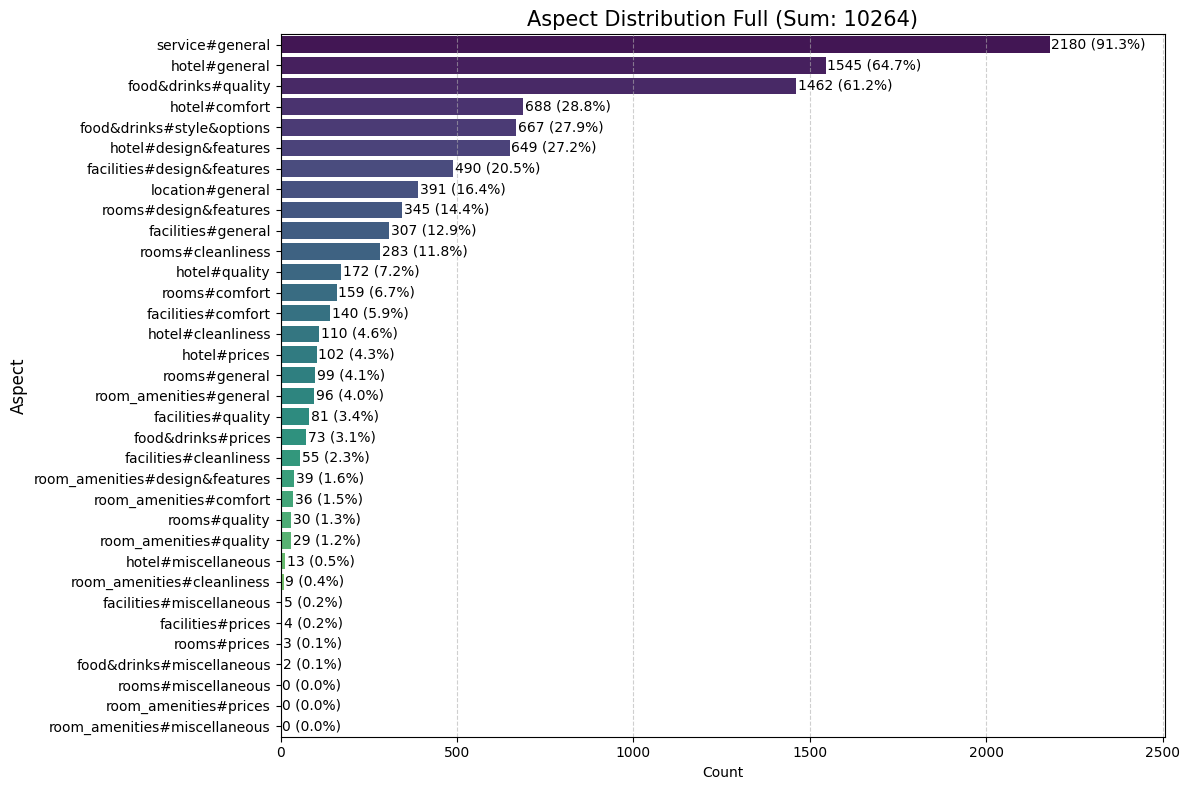

C:\Users\tranm\AppData\Local\Temp\ipykernel_11220\4060975661.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_counts, x='Count', y='Aspect', palette='viridis')


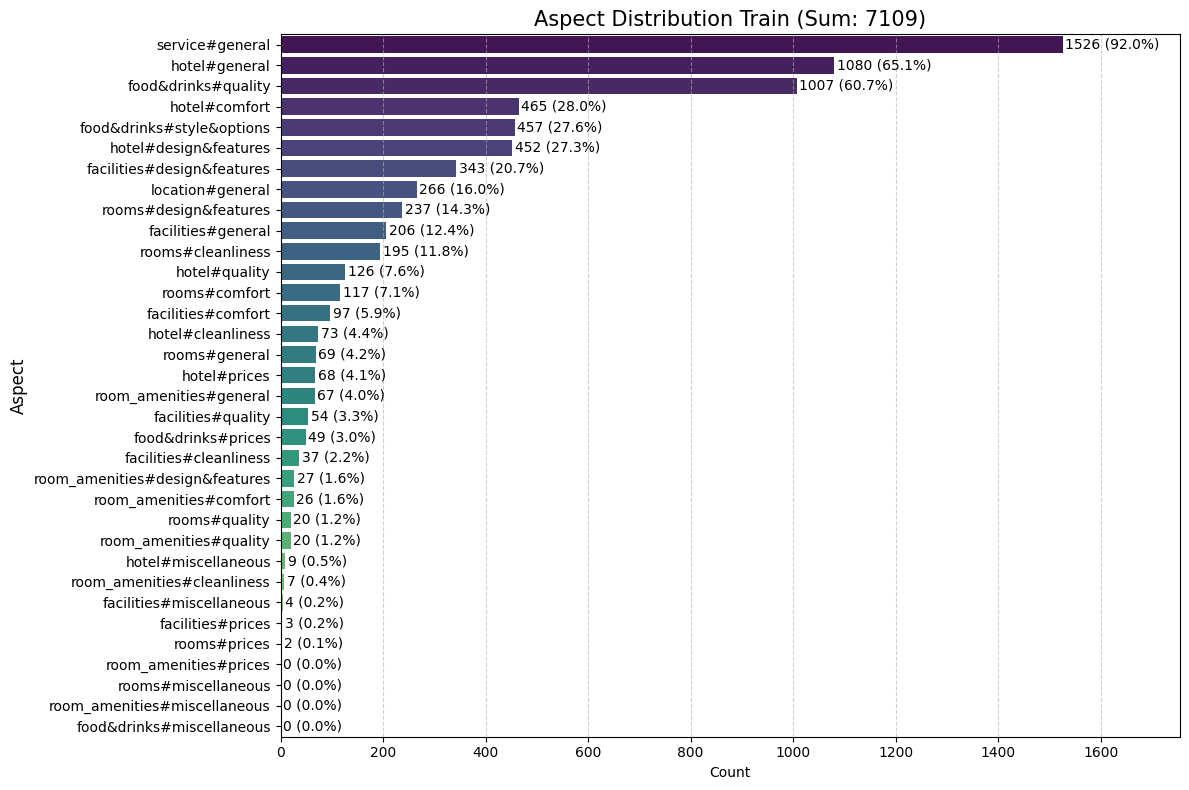

C:\Users\tranm\AppData\Local\Temp\ipykernel_11220\4060975661.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_counts, x='Count', y='Aspect', palette='viridis')


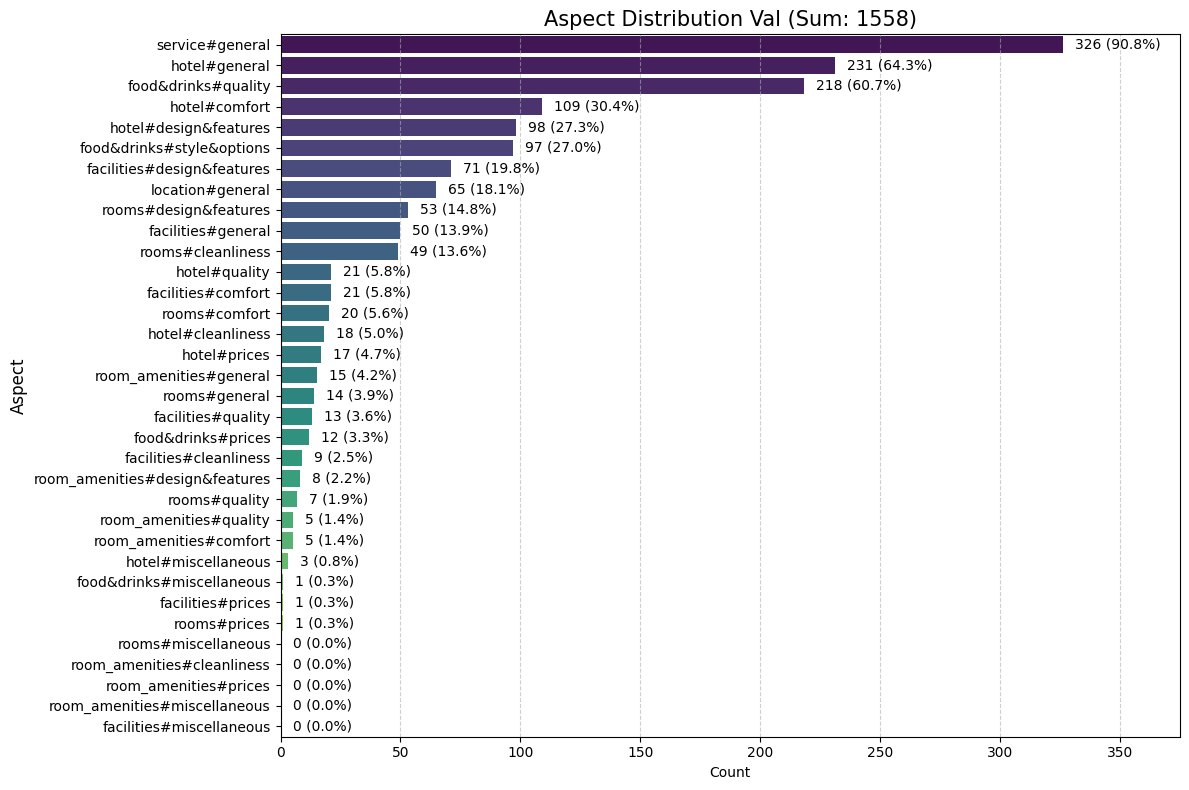

C:\Users\tranm\AppData\Local\Temp\ipykernel_11220\4060975661.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_counts, x='Count', y='Aspect', palette='viridis')


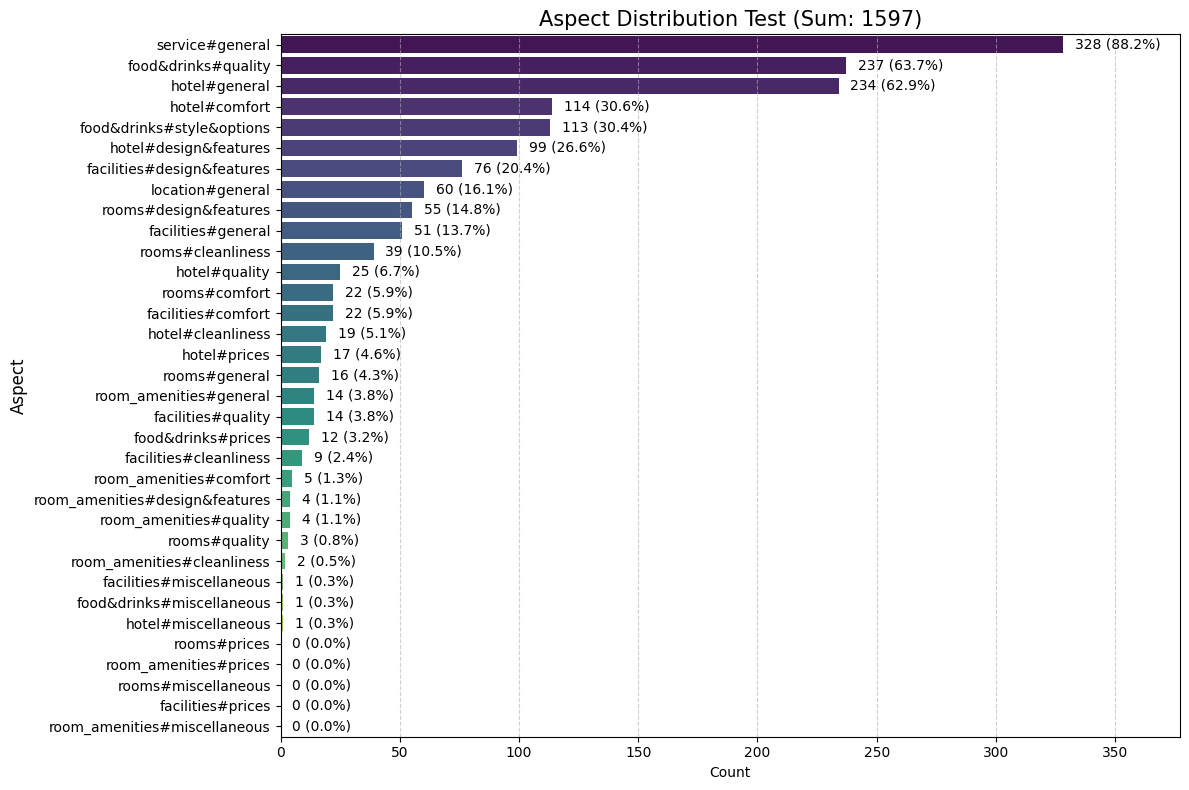

In [16]:
plot_aspect_distribution(data, title_suffix="Full")
plot_aspect_distribution(train_df, title_suffix="Train")
plot_aspect_distribution(val_df, title_suffix="Val")
plot_aspect_distribution(test_df, title_suffix="Test")

C:\Users\tranm\AppData\Local\Temp\ipykernel_16620\2156315892.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_long, x='Polarity',


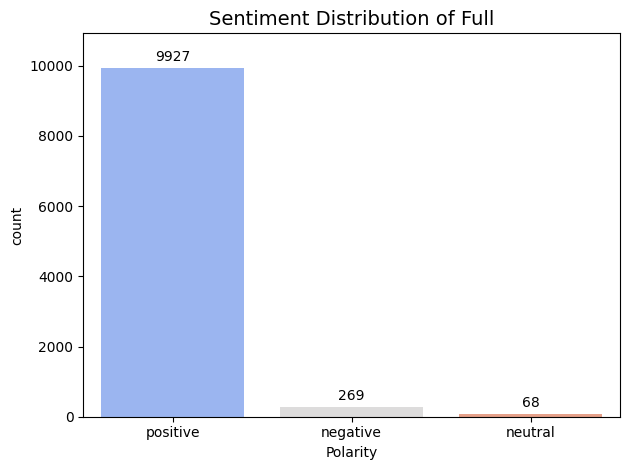

C:\Users\tranm\AppData\Local\Temp\ipykernel_16620\2156315892.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_long, x='Polarity',


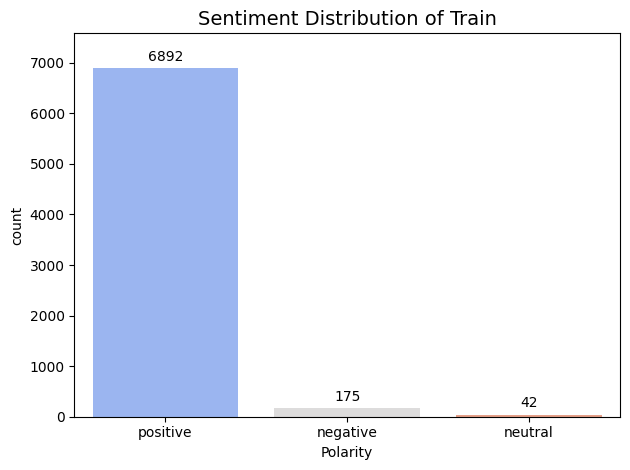

C:\Users\tranm\AppData\Local\Temp\ipykernel_16620\2156315892.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_long, x='Polarity',


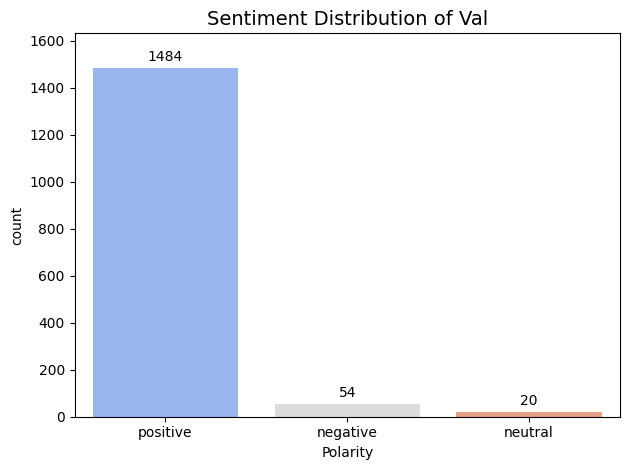

C:\Users\tranm\AppData\Local\Temp\ipykernel_16620\2156315892.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_long, x='Polarity',


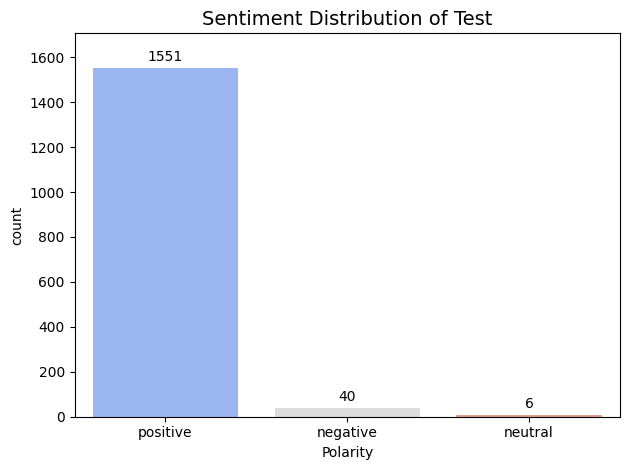

In [17]:
plot_sentiment_distribution(data, title_suffix="Full")
plot_sentiment_distribution(train_df, title_suffix="Train")
plot_sentiment_distribution(val_df, title_suffix="Val")
plot_sentiment_distribution(test_df, title_suffix="Test")

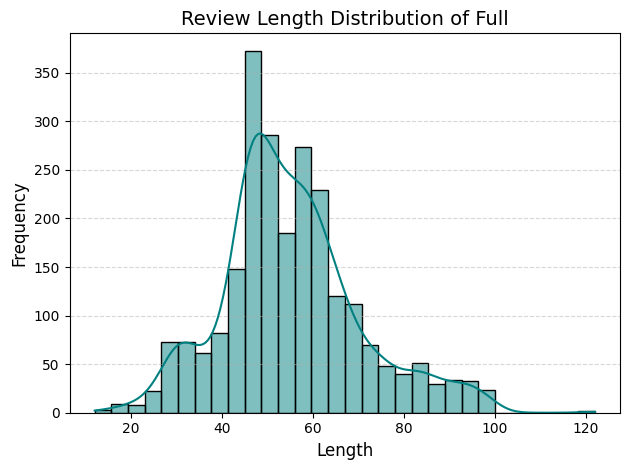

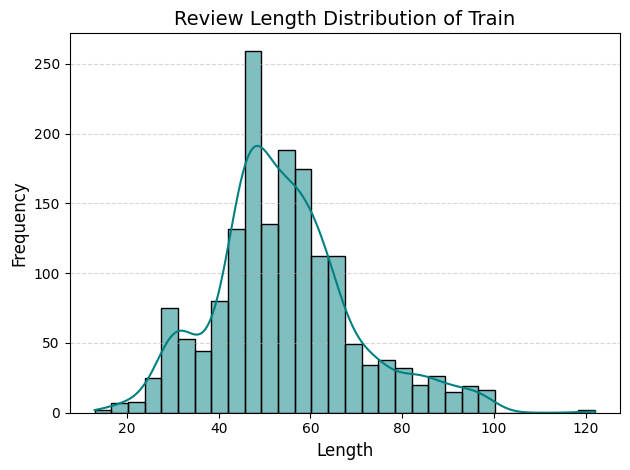

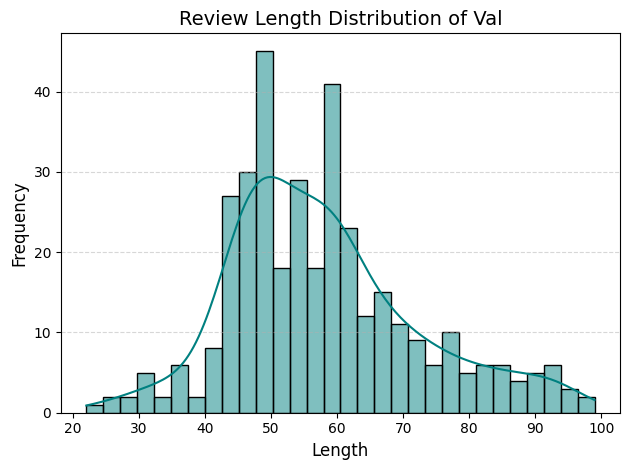

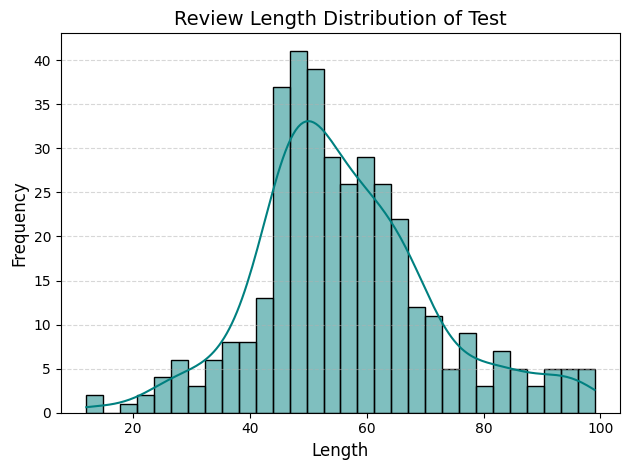

In [18]:
plot_review_length_distribution(data, title_suffix="Full")
plot_review_length_distribution(train_df, title_suffix="Train")
plot_review_length_distribution(val_df, title_suffix="Val")
plot_review_length_distribution(test_df, title_suffix="Test")